<h1> Objective </h1>
<blockquote>
    
Predict the class of breast cancer (malignant or ‘bad’ versus benign or ‘good’) from the features of images taken from breast samples.
    
</blockquote>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from scipy.stats import ttest_ind
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
sns.set()

<h2> Loading in dataset </h2>


In [2]:
cancer_df =  pd.read_csv('data/cancer.data', sep=",")

<h2> Examining the dataset </h2>


In [3]:
cancer_df.head()

,1000025,5,1,1.1,1.2,2,1.3,3,1.4,1.5,2.1
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4


In [4]:
cancer_df.rename(columns = {'1000025': 'Sample code number', '5': 'Clump Thickness', '1': 'Uniformity of Cell Size'
                            , '1.1': 'Uniformity of Cell Shape', '1.2': 'Marginal Adhesion', '2': 'Single Epithelial Cell Size'
                            , '1.3': 'Bare Nuclei', '3': 'Bland Chromatin', '1.4': 'Normal Nucleoli', '1.5': 'Mitoses'
                            , '2.1': 'Class'}, inplace = True)

In [5]:
cancer_df['Class'] = cancer_df['Class'].map({2: 0, 4: 1})

In [6]:
cancer_df['Class'].value_counts()

0    457
1    241
Name: Class, dtype: int64

In [7]:
cancer_df.isnull().sum()

Sample code number             0
Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

There aren't any null values or empty columns.

In [8]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sample code number           698 non-null    int64 
 1   Clump Thickness              698 non-null    int64 
 2   Uniformity of Cell Size      698 non-null    int64 
 3   Uniformity of Cell Shape     698 non-null    int64 
 4   Marginal Adhesion            698 non-null    int64 
 5   Single Epithelial Cell Size  698 non-null    int64 
 6   Bare Nuclei                  698 non-null    object
 7   Bland Chromatin              698 non-null    int64 
 8   Normal Nucleoli              698 non-null    int64 
 9   Mitoses                      698 non-null    int64 
 10  Class                        698 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


In [9]:
cancer_df.drop(['Sample code number'],axis=1,inplace=True)

<blockquote>

All the columns are of type integer execpt for 1.3. I'll have to change that later on to int so that I can use it to create a model. The first column *Sample code number* which is the ID column I'll drop as it won't give us any information as to how to predict the class of breast cancer.

</blockquote>


In [10]:
# Replace the '?'s with NaN
cancer_df["Bare Nuclei"].replace('?', np.nan, inplace = True)

# Inspect the missing values again
# ... YOUR CODE FOR TASK 3 ...
cancer_df.isnull().sum()

Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64

<blockquote>
    The data contains <b>"?"</b> in the 1.3 column which will create a problem when we try and build a model as a logistic regression model can only be built with numeric data types. So I'll replace the question marks with <b>Nan</b> values and then fill them with the mode value.
    </blockquote>

In [11]:
cancer_df.fillna({"Bare Nuclei":cancer_df["Bare Nuclei"].value_counts().index[0]}, inplace=True)

In [12]:
cancer_df.isnull().sum()

Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

In [13]:
cancer_df = cancer_df.astype({"Bare Nuclei": int})

<h2> Feature Selection </h2>


Text(0.5, 1.0, 'Features Correlating with Class')

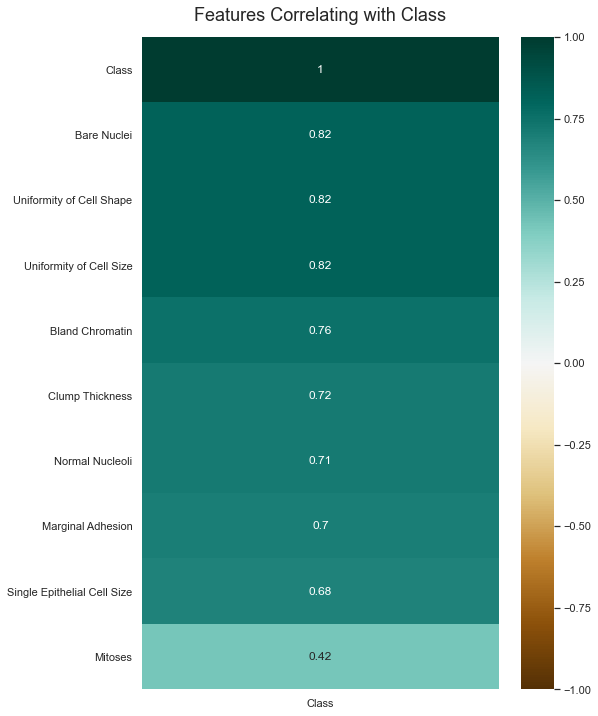

In [14]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(cancer_df.corr()[['Class']].sort_values(by='Class', ascending=False)
                      , vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Class', fontdict={'fontsize':18}, pad=16)

<blockquote>
    Since logistic regression is a linear model, I am looking at the the correlation between the features and target variable. Anything with a correlation of 7 or higher is what I will consider as possible features to use. So from looking at the graph above I could use all the features except for Single Epithelial Cell Size and Mitoses as features because those two have a very low correlation with the target variable. 
    </blockquote>

In [15]:
features = cancer_df[['Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses']]
model=XGBClassifier()
 
model.fit(features,cancer_df['Class'])
 
feature_importances=pd.DataFrame({'features':features.columns,'feature_importance':model.feature_importances_})
print(feature_importances.sort_values('feature_importance',ascending=False))

[14:12:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                      features  feature_importance
1      Uniformity of Cell Size            0.523232
2     Uniformity of Cell Shape            0.280412
5                  Bare Nuclei            0.071188
0              Clump Thickness            0.033943
6              Bland Chromatin            0.025516
4  Single Epithelial Cell Size            0.020297
7              Normal Nucleoli            0.018938
3            Marginal Adhesion            0.013918
8                      Mitoses            0.012557


C:\Users\keanu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


<blockquote>
 I then used feature importance in order to determine the importance of each of the features. What's interesting to note is that single Single Epithelial Cell Size is more important than Normal Nucleoli and Marginal Adhesion even though these attributes have a higher correlation with the target variable. This could mean that the relationship between Single Epithelial Cell Size and the target variable is more significant.
</blockquote>

In [16]:
Epithelial = ttest_ind(cancer_df['Single Epithelial Cell Size'], cancer_df['Class'])
print("Single Epithelial Cell Size: {}".format(Epithelial))
Nucleoli = ttest_ind(cancer_df['Normal Nucleoli'], cancer_df['Class'])
print("Normal Nucleoli: {}".format(Nucleoli))
Adhesion = ttest_ind(cancer_df['Marginal Adhesion'], cancer_df['Class'])
print("Marginal Adhesion: {}".format(Adhesion))

Single Epithelial Cell Size: Ttest_indResult(statistic=33.49199893428085, pvalue=6.237146597717567e-181)
Normal Nucleoli: Ttest_indResult(statistic=21.570593923274092, pvalue=2.790817623490851e-89)
Marginal Adhesion: Ttest_indResult(statistic=22.48061879783499, pvalue=9.448093511044219e-96)


<blockquote>
 So looking at this in terms of the features I am selecting, it is quite clear why Mitoses will be a bad feature to model with. Mitoses has the lowest correlation with the target variable, the lowest importance and it has baises which I explore later in the graph I've plotted. Now looking at the features Single Epithelial Cell Size, Normal Nucleoli, Marginal Adhesion althought they have very small p-values telling us that their relationship with the target variable is statistically significant. I will not use them to model. This is because p-value is an analysis of how each independent variable is individually related to the target variable. P-value test does not consider the relationship between two variables, thus the features with p_value > 0.05 might actually be important and vice versa. This affects regression models such as the one here where we have multiple variables. It could indeed be the case that, on their these features have predictive power but when combined with the other features will actually deter the performance of the model. Therefore, I will consider the information given to me by feature importance as more important because it takes into account how each of the variables perform when combined with the others. 
    </blockquote>

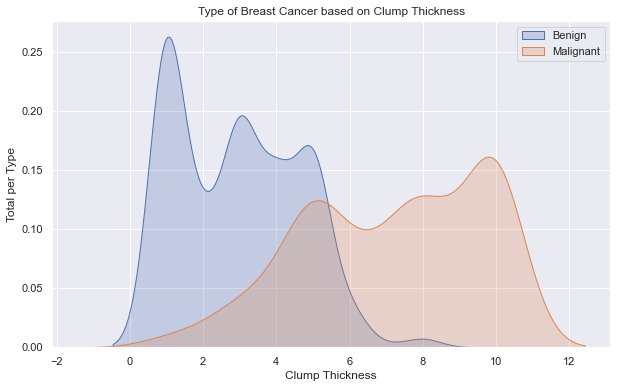

In [17]:
plt.figure(figsize=(10,6))
sns.kdeplot(cancer_df[cancer_df['Class'] == 0]['Clump Thickness'], shade=True,label="Benign")
sns.kdeplot(cancer_df[cancer_df['Class'] == 1]['Clump Thickness'], shade=True,label="Malignant")
plt.title('Type of Breast Cancer based on Clump Thickness')
plt.ylabel('Total per Type')
plt.xlabel('Clump Thickness')
plt.legend(['Benign','Malignant'])

<blockquote>

Looking at this this graph we can see that when clump thickness>5 it is highly likely that it is malignant. As the clump thickness increases it is even more likely that it will be Malignant. When clump thickness < 5 it is more likely that the tumor is benign. 

</blockquote>


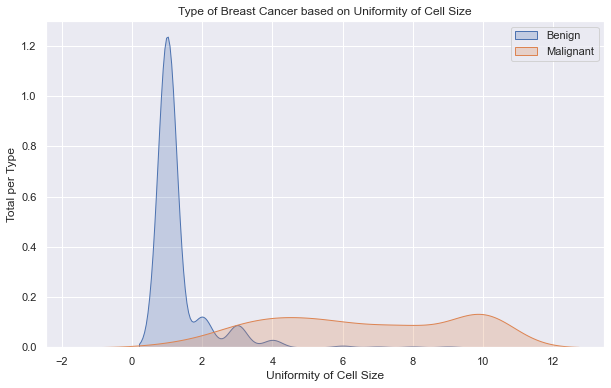

In [18]:
plt.figure(figsize=(10,6))
sns.kdeplot(cancer_df[cancer_df['Class'] == 0]['Uniformity of Cell Size'], shade=True,label="Benign")
sns.kdeplot(cancer_df[cancer_df['Class'] == 1]['Uniformity of Cell Size'], shade=True,label="Malignant")
plt.title('Type of Breast Cancer based on Uniformity of Cell Size')
plt.ylabel('Total per Type')
plt.xlabel('Uniformity of Cell Size')
plt.legend(['Benign','Malignant'])

<bLockquote>
    This would be a good feature to use for modelling. Looking at this graph we can see that it would be a good classifier for 
    Bening or Malignant tumors. With Uniformity of Cell Size above 3 most likely being Malignant and anything below that being Benign.
</blockquote>

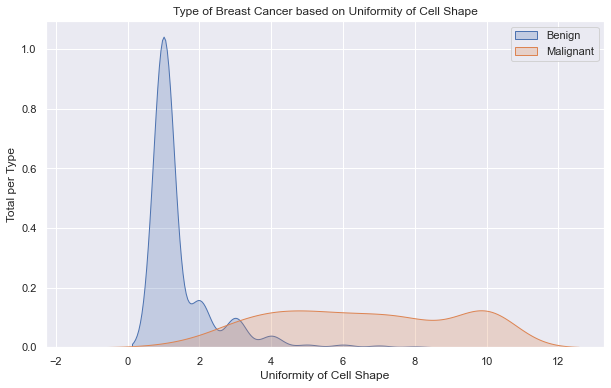

In [19]:
plt.figure(figsize=(10,6))
sns.kdeplot(cancer_df[cancer_df['Class'] == 0]['Uniformity of Cell Shape'], shade=True,label="Benign")
sns.kdeplot(cancer_df[cancer_df['Class'] == 1]['Uniformity of Cell Shape'], shade=True,label="Malignant")
plt.title('Type of Breast Cancer based on Uniformity of Cell Shape')
plt.ylabel('Total per Type')
plt.xlabel('Uniformity of Cell Shape')
plt.legend(['Benign','Malignant'])

<bLockquote>
    This would be a good feature to use for modelling. Looking at this graph we can see that it would be a good classifier for 
    Bening or Malignant tumors. With Uniformity of Cell Shape above 3 most likely being Malignant and anything below that being Benign.
</blockquote>

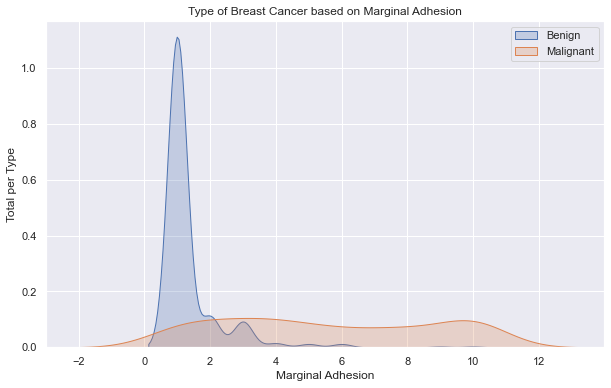

In [20]:
plt.figure(figsize=(10,6))
sns.kdeplot(cancer_df[cancer_df['Class'] == 0]['Marginal Adhesion'], shade=True,label="Benign")
sns.kdeplot(cancer_df[cancer_df['Class'] == 1]['Marginal Adhesion'], shade=True,label="Malignant")
plt.title('Type of Breast Cancer based on Marginal Adhesion')
plt.ylabel('Total per Type')
plt.xlabel('Marginal Adhesion')
plt.legend(['Benign','Malignant'])

<bLockquote>
    This would be a good feature to use for modelling. Looking at this graph we can see that it would be a good classifier for 
    Bening or Malignant tumors. With Marginal Adhesion above 3 most likely being Malignant and anything below that being Benign. However I will not use this feature to model as it ranked low on feature importance.
</blockquote>

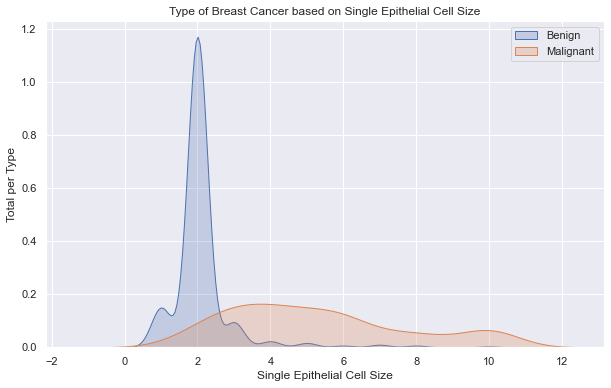

In [21]:
plt.figure(figsize=(10,6))
sns.kdeplot(cancer_df[cancer_df['Class'] == 0]['Single Epithelial Cell Size'], shade=True,label="Benign")
sns.kdeplot(cancer_df[cancer_df['Class'] == 1]['Single Epithelial Cell Size'], shade=True,label="Malignant")
plt.title('Type of Breast Cancer based on Single Epithelial Cell Size')
plt.ylabel('Total per Type')
plt.xlabel('Single Epithelial Cell Size')
plt.legend(['Benign','Malignant'])

<blockquote>
    This would not be a good feature to use as it has an undercoverage bias. From 3 onwards the reasearch population is not being represented accurately. There is not enough data that has been collected in order for us to determine if there actually is a relationship between Breast Cancer and Single Epithelial Cell Size. There is a high concentration of data around two creating this bias. That in and of it self is not enough in order for us to predict future samples. Adding this to the model will make it learn in correct biases that will cause it to make incorrect predictions in the future. Also it ranked low on feature importance and has a low correlation with the target variable.
   </blockquote>

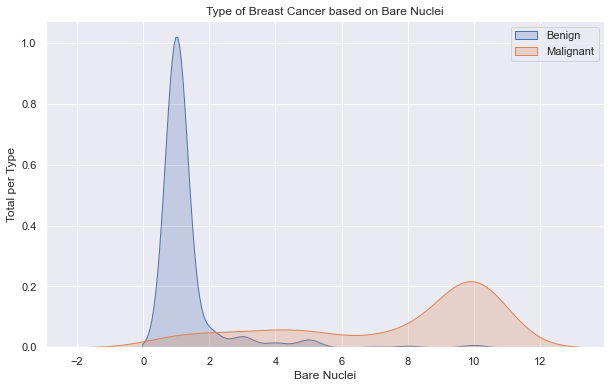

In [22]:
plt.figure(figsize=(10,6))
sns.kdeplot(cancer_df[cancer_df['Class'] == 0]['Bare Nuclei'], shade=True,label="Benign")
sns.kdeplot(cancer_df[cancer_df['Class'] == 1]['Bare Nuclei'], shade=True,label="Malignant")
plt.title('Type of Breast Cancer based on Bare Nuclei')
plt.ylabel('Total per Type')
plt.xlabel('Bare Nuclei')
plt.legend(['Benign','Malignant'])

<bLockquote>
    This would be a good feature to use for modelling. Looking at this graph we can see that it would be a good classifier for 
    Bening or Malignant tumors. With Bare Nuclei above 3 most likely being Malignant and anything below that being Benign.
</blockquote>

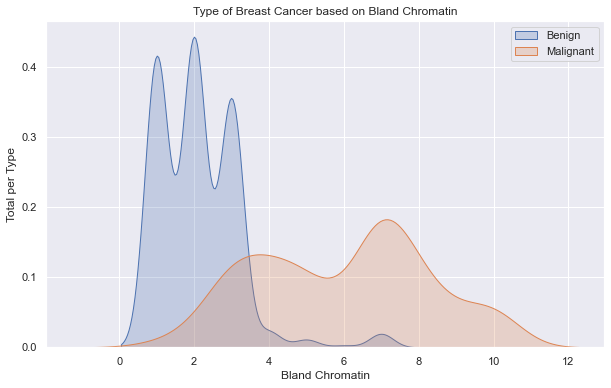

In [23]:
plt.figure(figsize=(10,6))
sns.kdeplot(cancer_df[cancer_df['Class'] == 0]['Bland Chromatin'], shade=True,label="Benign")
sns.kdeplot(cancer_df[cancer_df['Class'] == 1]['Bland Chromatin'], shade=True,label="Malignant")
plt.title('Type of Breast Cancer based on Bland Chromatin')
plt.ylabel('Total per Type')
plt.xlabel('Bland Chromatin')
plt.legend(['Benign','Malignant'])

<bLockquote>
    This would be a good feature to use for modelling. Looking at this graph we can see that it would be a good classifier for 
    Bening or Malignant tumors. With Bland Chromatin above 3 most likely being Malignant and anything below that being Benign.
</blockquote>

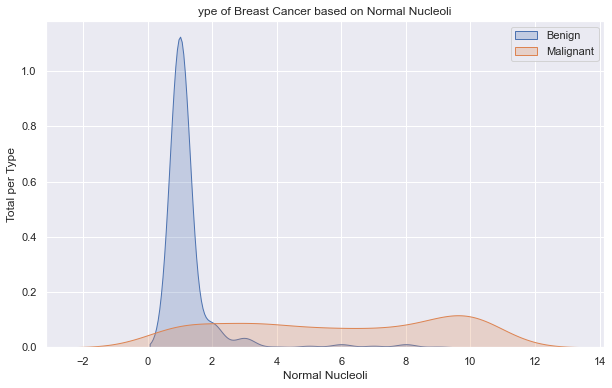

In [24]:
plt.figure(figsize=(10,6))
sns.kdeplot(cancer_df[cancer_df['Class'] == 0]['Normal Nucleoli'], shade=True,label="Benign")
sns.kdeplot(cancer_df[cancer_df['Class'] == 1]['Normal Nucleoli'], shade=True,label="Malignant")
plt.title('ype of Breast Cancer based on Normal Nucleoli')
plt.ylabel('Total per Type')
plt.xlabel('Normal Nucleoli')
plt.legend(['Benign','Malignant'])

<bLockquote>
    This would be a good feature to use for modelling. Looking at this graph we can see that it would be a good classifier for 
    Bening or Malignant tumors. With Normal Nucleoli above 3 most likely being Malignant and anything below that being Benign.  However I will not use this feature to model because it ranked low on feature importance.
</blockquote>

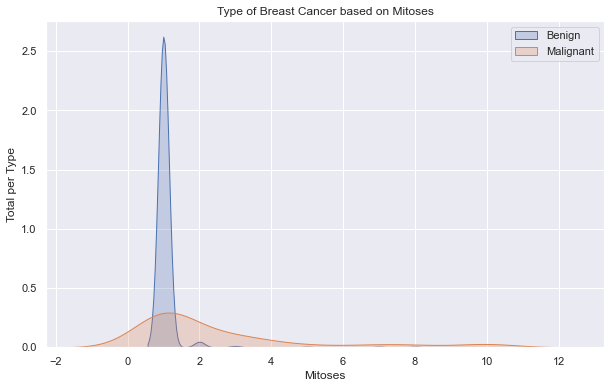

In [25]:
plt.figure(figsize=(10,6))
sns.kdeplot(cancer_df[cancer_df['Class'] == 0]['Mitoses'], shade=True,label="Benign")
sns.kdeplot(cancer_df[cancer_df['Class'] == 1]['Mitoses'], shade=True,label="Malignant")
plt.title('Type of Breast Cancer based on Mitoses')
plt.ylabel('Total per Type')
plt.xlabel('Mitoses')
plt.legend(['Benign','Malignant'])

<blockquote>
    This would not be a good feature to use as it has an undercoverage bias. From 2 onwards the reasearch population is not being represented accurately. There is not enough data that has been collected in order for us to determine if there actually is a relationship between Breat Cancer and Mistoses. There is a high concentration of data around one. That in and of it self is not enough in order for us to predict future samples. Adding this to the model will make it learn in correct biases that will cause it to make incorrect predictions in the future. 
   </blockquote>

<h1> Splitting Data </h1>

In [26]:
x = cancer_df[['Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Bland Chromatin',
       'Bare Nuclei']]
y = cancer_df['Class']

In [27]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.30,random_state=1)

<h1> Modelling </h1>

In [28]:
LogReg = LogisticRegression(random_state=1, solver='lbfgs').fit(x_train, y_train)

In [29]:
y_pred = LogReg.predict(x_test)
x_pred = LogReg.predict(x_train)

print("Test acurracy {}".format(accuracy_score(y_test,y_pred)))
print("Train acurracy {}".format(accuracy_score(y_train,x_pred)))

Test acurracy 0.9619047619047619
Train acurracy 0.9651639344262295


<blockquote>
The model has an Test acurracy 0.9619047619047619 and Train acurracy 0.9651639344262295. This means that it has a very high accuracy and is performing really well. There are no signs of overfitting as the test and train accuracy scores don't have a very wide variance. There's no signs of underfitting as the train accuracy is higher than the test accuracy which is expected because the this is the data that the model learnt on and has seen before so it should be better at predicting that. 
    </blockquote>

   <h2>Test Confusion Matrix</h2>


Text(0.5, 257.44, 'Predicted label')

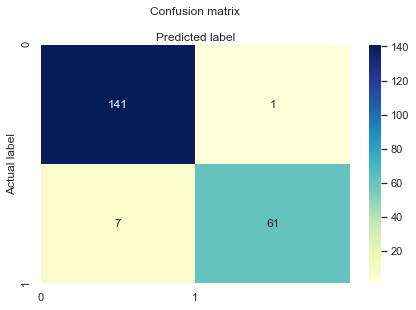

In [30]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred)), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.set(yticks=[0, 2], 
       xticks=[0, 1], 
       yticklabels=class_names, 
       xticklabels=class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

<blockquote>
We have <b>141 True Positives</b> and there are <b>1 False Positive</b>. We have <b>7 False Negatives</b>, and there are <b>61  True Negatives</b>. Overall the model is classifying more values correctly than incorrectly, therefore it is performing well.
</blockquote>

 <h2>Train Confusion Matrix</h2>


Text(0.5, 257.44, 'Predicted label')

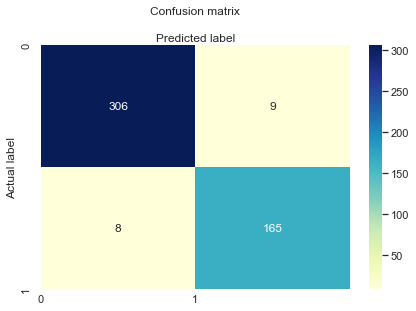

In [31]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names,va="center")
plt.yticks(tick_marks, class_names,va="center")
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, x_pred)), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.set(yticks=[0, 2], 
       xticks=[0, 1], 
       yticklabels=class_names, 
       xticklabels=class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

<blockquote>
We have <b>306 True Positives</b> and there are <b>9 False Positives</b>. We have <b>8 False Negatives</b>, and there are <b>165 True Negative</b>. Overall the model is classifying more values correctly than incorrectly, therefore it is performing well.
</blockquote>

<h2>Test Classification Report</h2>


In [32]:
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))

              precision    recall  f1-score   support

      Benign       0.95      0.99      0.97       142
   Malignant       0.98      0.90      0.94        68

    accuracy                           0.96       210
   macro avg       0.97      0.95      0.96       210
weighted avg       0.96      0.96      0.96       210



<blockquote>

It has a precision score 0.95 for benign tumors meaning that 95% of the predicted cases were correct. It has a precision score 0.98 for malignant tumors meaning that 98% of the predicted cases were correct. The recall score is 0.99 for benign tumors meaning that 99% of the observed cases were correctly predicted.The recall score is 0.90 for malignant tumors meaning that 90% of the observed cases were correctly predicted. We have an f1 score of 0.97 for beninging tumors and 0.94 for malignant tumors. Overall looking at these scores we can see that the model is performing very well. I have high precision and high recall meaning that the model will perform well and correctly classify the class of cancer. So where people have people have benign or malignant cancer types the model will actually classify them correctly. 

</blockquote>

<h2>Train Classification Report</h2>


In [33]:
print(classification_report(y_train, x_pred, target_names=['Benign', 'Malignant']))

              precision    recall  f1-score   support

      Benign       0.97      0.97      0.97       315
   Malignant       0.95      0.95      0.95       173

    accuracy                           0.97       488
   macro avg       0.96      0.96      0.96       488
weighted avg       0.97      0.97      0.97       488



<blockquote>

It has a precision score 0.97 for benign tumors meaning that 97% of the predicted cases were correct. It has a precision score 0.95 for malignant tumors meaning that 95% of the predicted cases were correct. The recall score is 0.97 for benign tumors meaning that 97% of the observed cases were correctly predicted.The recall score is 0.95 for malignant tumors meaning that 95% of the observed cases were correctly predicted. We have an f1 score of 0.97 for beninging tumors and 0.95 for malignant tumors. Overall looking at these scores we can see that the model is performing very well. I have high precision and high recall meaning that the model will perform well and correctly classify the class of cancer. So where people have people have benign or malignant cancer types the model will actually classify them correctly. 

</blockquote>

<h2>Test ROC Curve</h2>


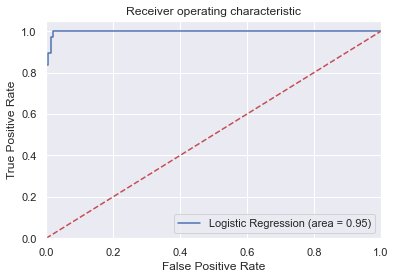

In [34]:
logit_roc_auc = roc_auc_score(y_test,y_pred)
fpr, tpr, thresholds = roc_curve(y_test, LogReg.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

<blockquote>
    Looking at the ROC curve and the area = 0.95 under the ROC curve we can see that the model is performing very well.

</blockquote>

<h2>Train ROC Curve</h2>


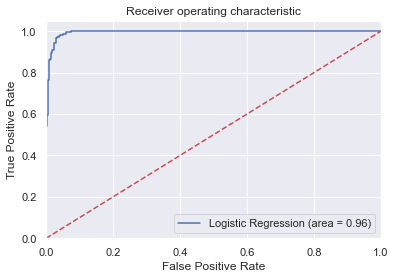

In [35]:
logit_roc_auc = roc_auc_score(y_train, x_pred)
fpr, tpr, thresholds = roc_curve(y_train, LogReg.predict_proba(x_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

<blockquote>
    Looking at the ROC curve and the area = 0.96 under the ROC curve we can see that the model is performing very well. It makes sense for this score to be higher as this is the data the model has seen before and was trained on. So it would predict it more accura

</blockquote>

<h1>Overdispersion</h1>


<blockquote>
    Overdispersion is the presence of greater variability (statistical dispersion) in a data set than would be expected based on a given statistical model. When the variance is greater than the mean we can say that there is overdispersion.
    </blockquote>

<h2>Overdispersion Test Data</h2>


In [36]:
print("Variance % s" %(statistics.variance(y_pred)))

Variance 0


In [37]:
print("Mean % s" %(statistics.mean(y_pred)))

Mean 0


<blockquote>
In this case there is no overdispersion as mean = variance. Meaning that the model is displaying the amount of variance expected.
</blockquote>

<h2>Overdispersion Train Data</h2>


In [38]:
print("Variance % s" %(statistics.variance(x_pred)))

Variance 0


In [39]:
print("Mean % s" %(statistics.mean(x_pred)))

Mean 0


<blockquote>
In this case there is no overdispersion as mean = variance. Meaning that the model is displaying the amount of variance expected.
</blockquote>